# Lie Detection: Reliability of Relevant Predictors in Classifiers

[INTRODUCTION OF THE PROBLEM HERE]

### Datasets:
[ADD AND COMMENT ABOUT DATASETS HERE]
### Tasks:
[ADD TASK HERE]

### Integrants:
Name, Matricola, Email respectively
- Santiago Víquez Segura, 2048722, santiago.viquezsegura@studenti.unipd.it
- Phillippe Robert, 2041505, philippe.robert@studenti.unipd.it
- Huzaifa Fazal,

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.ensemble import  RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn import svm
import shap
# figure size in inches
plt.rcParams['figure.figsize'] = 11.7,8.27

## Load datasets

In [34]:
BF_CTU_df = pd.read_csv("data/BF_df_CTU.csv", delimiter=",")
BF_OU_df = pd.read_csv("data/BF_df_OU.csv", delimiter=",")
BF_V_df = pd.read_csv("data/BF_df_V.csv", delimiter=",")
DT_CC_df = pd.read_csv("data/DT_df_CC.csv", delimiter=",")
DT_JI_df = pd.read_csv("data/DT_df_JI.csv", delimiter=";")
IADQ_df = pd.read_csv("data/IADQ_df.csv", delimiter=",")
IESR_df = pd.read_csv("data/IESR_df.csv", delimiter=",")
NAQR_df = pd.read_csv("data/NAQ_R_df.csv", delimiter=";")
PCL5_df = pd.read_csv("data/PCL5_df.csv", delimiter=";")
PHQ9_df = pd.read_csv("data/PHQ9_GAD7_df.csv", delimiter=";")
PID5_df = pd.read_csv("data/PID5_df.csv", delimiter=";")
PRFQ_df = pd.read_csv("data/PRFQ_df.csv", delimiter=",")
PRMQ_df = pd.read_csv("data/PRMQ_df.csv", delimiter=",")
DDDT_df = pd.read_csv("data/RAW_DDDT.CSV", delimiter=",")
SPID5_df = pd.read_csv("data/sPID-5_df.csv", delimiter=",")
RNEOPI_honest_df = pd.read_excel("data/Honest.xlsx", header=1)
RNEOPI_fake_df = pd.read_excel("data/Faked.xlsx", header=1)

## Helper Functions

In [3]:
def evaluate_clf(df, clf, cv):
    """
    Performs cross-validation of a classifier over a dataset
    
    Args:
        df: (pd.DataFrame) train dataset
        clf: (sklearn fitted estimator)
        cv: (int) number of folds
        
    Returns:
        output: (dict) {fit_time:[...], score_time:[...], estimator:[...], test_score:[...]}
    """
    X = df.loc[:, df.columns != 'CONDITION'] # select all columns except CONDITION
    y = np.where(df["CONDITION"] == "H", 1, 0)
    output = cross_validate(clf, X, y, cv=cv, scoring='f1', return_estimator=True)
    
    return output

In [4]:
def get_feature_importance(model_output):
    """
    Averages feature importances / coefficient values from all the fitted estimators
    
    Args:
        model_output: (list) sklearn fitted estimators
    
    Retruns: (dict) {predictor: value}
    """
    
    n_folds = len(output["estimator"])
    coeficients = 0
    
    for estimator in output["estimator"]:
        if isinstance(estimator, LogisticRegression) or isinstance(estimator, svm.SVC):
            coeficients += estimator.coef_[0] # TODO: RF uses feature_importances insted of coef_
        else:
            coeficients += estimator.feature_importances_
    coeficients = np.abs(coeficients/n_folds)
    res = dict(zip(estimator.feature_names_in_, coeficients))

    return res

In [5]:
def plot_feature_importance(feature_importance, title):
    """
    Plots a bar chart of the importance/coefficients of the predictors
    
    Args:
        feature_importance: (dict) dictionary with key:feature name and value:importance
        title: (str) title of the chart
    """
    
    plt.bar(x=feature_importance.keys(), height=feature_importance.values())
    plt.title(title)
    plt.xlabel("Feature Name")
    plt.ylabel("Abs(Importance Score)")
    plt.show()

In [52]:
def get_shap_values(clf, df, cv):
    """
    Performs cross-validation of a classifier over a dataset
    and computes the shap-values for each fold.
    
    Args:
        df: (pd.DataFrame) train dataset
        clf: (sklearn fitted estimator)
        cv: (int) number of folds
        
    Returns:
        output: (tuple) shap_values: (shap.Explainer), f1_score: float
    """
    
    X = df.loc[:, df.columns != 'CONDITION'] # select all columns except CONDITION
    y = np.where(df["CONDITION"] == "H", 1, 0)

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    list_shap_values = list()
    f1_scores = list()
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #training model
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        f1_scores.append(f1_score(y_test, preds))

        #explaining model
        explainer = shap.Explainer(clf, X_train)
        if isinstance(clf, RandomForestClassifier):
            shap_values = explainer(X_test, check_additivity=False)
        else:
            shap_values = explainer(X_test)

        #for each iteration we save the test_set index and the shap_values
        list_shap_values.append(shap_values)
        
    # combining results from all iterations
    shap_values = np.array(list_shap_values[0].values)
    for i in range(1, cv):
        shap_values = np.concatenate((shap_values, np.array(list_shap_values[i].values)), axis=0)
    shap_values = shap.Explanation(shap_values, feature_names=X_train.columns)
    
    return shap_values, np.mean(f1_scores)

## Baseline Feature Importance - Shap Values

### Why Shap Values?

<AxesSubplot:xlabel='variable', ylabel='value'>

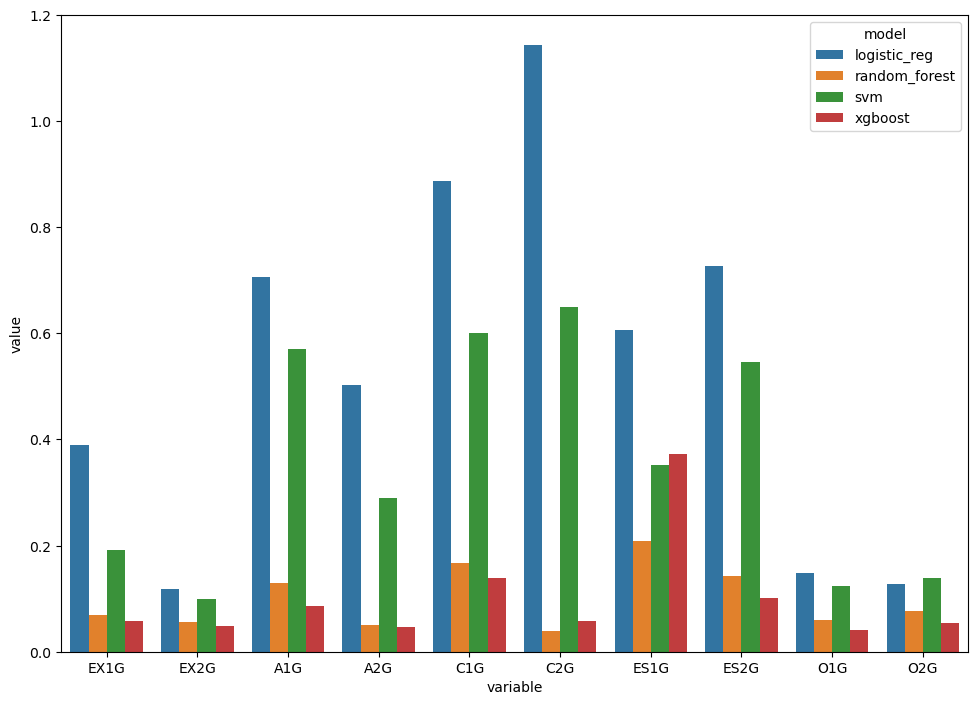

In [39]:
clf = LogisticRegression(solver="lbfgs", penalty="none")
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_lr = get_feature_importance(output)

clf = RandomForestClassifier(n_estimators=300, random_state=42)
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_rf = get_feature_importance(output)

clf = svm.SVC(kernel="linear")
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_svm = get_feature_importance(output)

clf = XGBClassifier(random_state=42)
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_xgboost = get_feature_importance(output)

feature_importance_lr['model'] ="logistic_reg"
feature_importance_rf['model'] ="random_forest"
feature_importance_svm['model'] ="svm"
feature_importance_xgboost['model'] ="xgboost"

comparison_df = pd.DataFrame.from_dict([feature_importance_lr, 
                        feature_importance_rf, 
                        feature_importance_svm,
                        feature_importance_xgboost])

comparison_df = comparison_df.melt(id_vars=["model"])

sns.barplot(data=comparison_df, x="variable", y="value", hue="model")

### Logistic Regression

Cross-Validated F1-Score: 0.8098047607227533


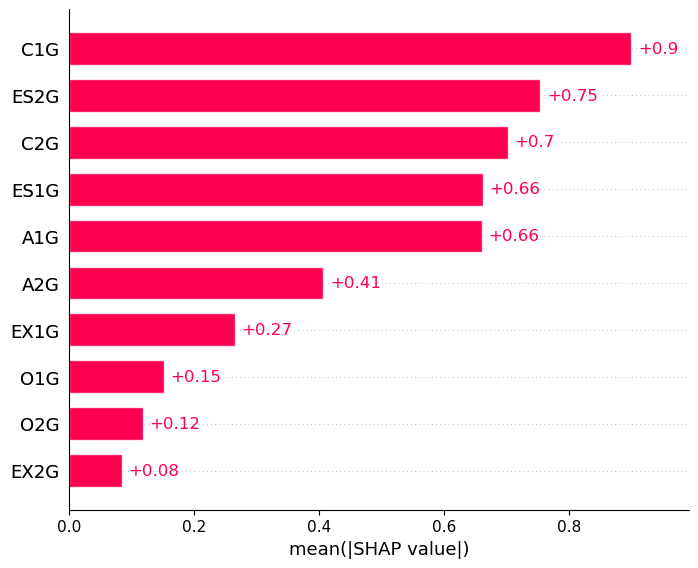

In [40]:
clf = LogisticRegression(solver="lbfgs", penalty="none")
shap_values_lr, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_lr)

### Random Forest

Cross-Validated F1-Score: 0.8264135923136632


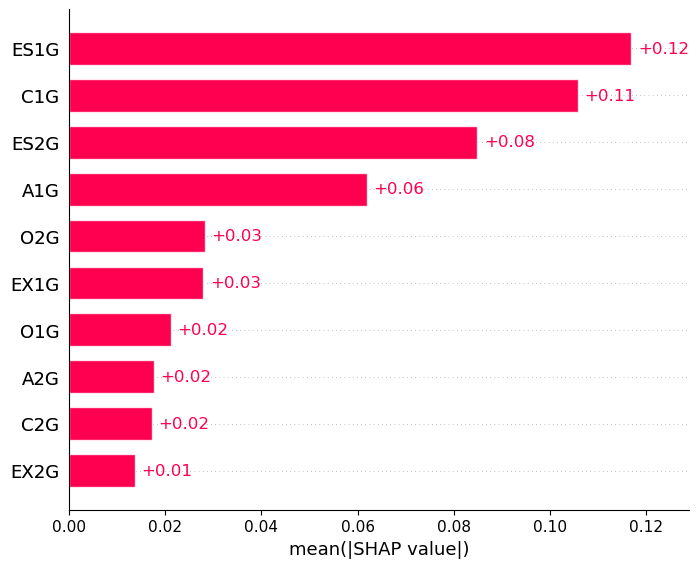

In [9]:
clf = RandomForestClassifier(random_state=42)
shap_values_rf, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_rf[:,:,1])

### SVM

Cross-Validated F1-Score: 0.8193417996883913


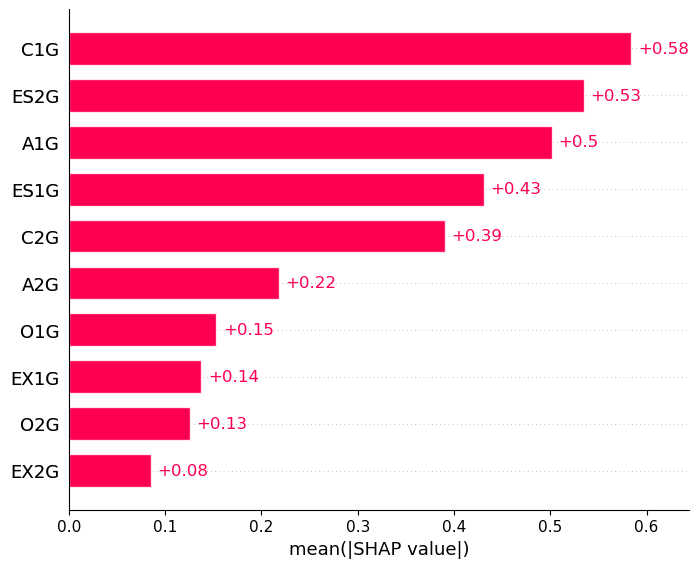

In [10]:
clf = svm.SVC(kernel="linear")
shap_values_svm, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_svm)

### XGBoost

Cross-Validated F1-Score: 0.8115609110462632


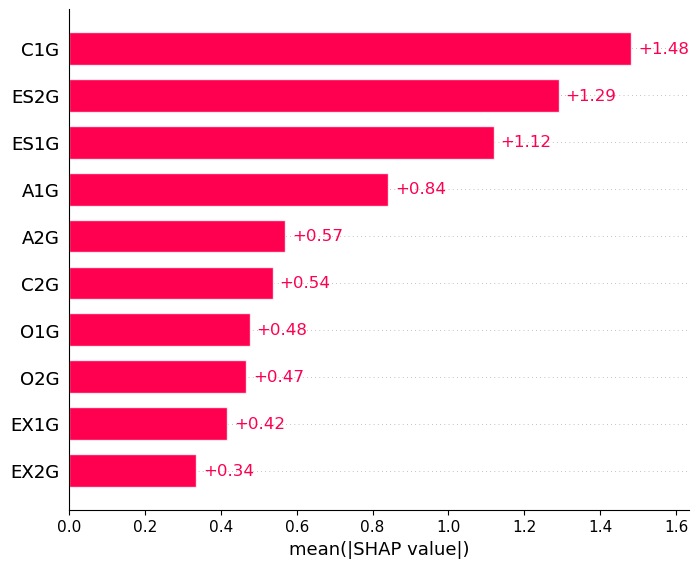

In [11]:
clf = XGBClassifier(random_state=42)
shap_values_xgboost, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_xgboost)

### Comparison Between Models

In [41]:
def compute_relative_shap_values(shap_values, col_names):    
    mean_shap_values = np.mean(np.abs(shap_values.values), axis=0)
    relative_shap_values = mean_shap_values / np.sum(mean_shap_values)
    relative_shap_values = dict(zip(col_names, relative_shap_values))
    return relative_shap_values

In [42]:
def compare_clfs(df, df_name:None, cv=5):
    lr = LogisticRegression(solver="lbfgs", penalty="none")
    shap_values_lr, f1 = get_shap_values(lr, df, cv)
    print(f"Cross-Validated F1-Score - Logistic Regression: {f1}")
    
    rf = RandomForestClassifier(random_state=42)
    shap_values_rf, f1 = get_shap_values(rf, df, cv)
    print(f"Cross-Validated F1-Score - Random Forest: {f1}")
    
    svm_c = svm.SVC(kernel="linear")
    shap_values_svm, f1 = get_shap_values(svm_c, df, cv)
    print(f"Cross-Validated F1-Score - SVM: {f1}")
    
    xgboost = XGBClassifier(random_state=42)
    shap_values_xgboost, f1 = get_shap_values(xgboost, df, cv)
    print(f"Cross-Validated F1-Score - XGBoost: {f1}")
    
    rel_shap_values_lr = compute_relative_shap_values(shap_values_lr, df.columns)
    rel_shap_values_rf = compute_relative_shap_values(shap_values_rf[:,:,1], df.columns)
    rel_shap_values_svm = compute_relative_shap_values(shap_values_svm, df.columns)
    rel_shap_values_xgboost = compute_relative_shap_values(shap_values_xgboost, df.columns)

    rel_shap_values_lr['model'] ="logistic_reg"
    rel_shap_values_rf['model'] ="random_forest"
    rel_shap_values_svm['model'] ="svm"
    rel_shap_values_xgboost['model'] ="xgboost"

    comparison_df = pd.DataFrame.from_dict([rel_shap_values_lr, 
                            rel_shap_values_rf, 
                            rel_shap_values_svm,
                            rel_shap_values_xgboost])

    comparison_df = comparison_df.melt(id_vars=["model"])

    ax = sns.barplot(data=comparison_df, x="variable", y="value", hue="model")
    ax.set_title(f'Shap Value Comparison - Data Set: {df_name}')
    ax.set_ylabel('Relative Shap Value Contribution')
    ax.set_xlabel('Feature')
    plt.show()

Cross-Validated F1-Score - Logistic Regression: 0.8098047607227533
Cross-Validated F1-Score - Random Forest: 0.8264135923136632
Cross-Validated F1-Score - SVM: 0.8193417996883913
Cross-Validated F1-Score - XGBoost: 0.8115609110462632


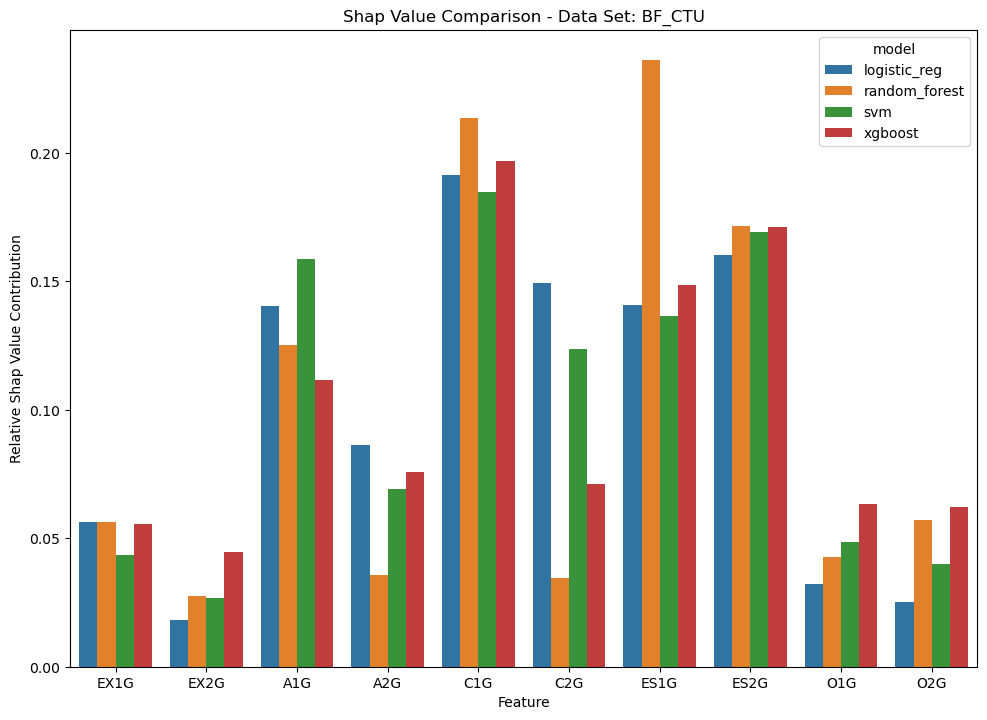

In [43]:
compare_clfs(BF_CTU_df, df_name="BF_CTU")

## Feature Selection Methods

### PCA

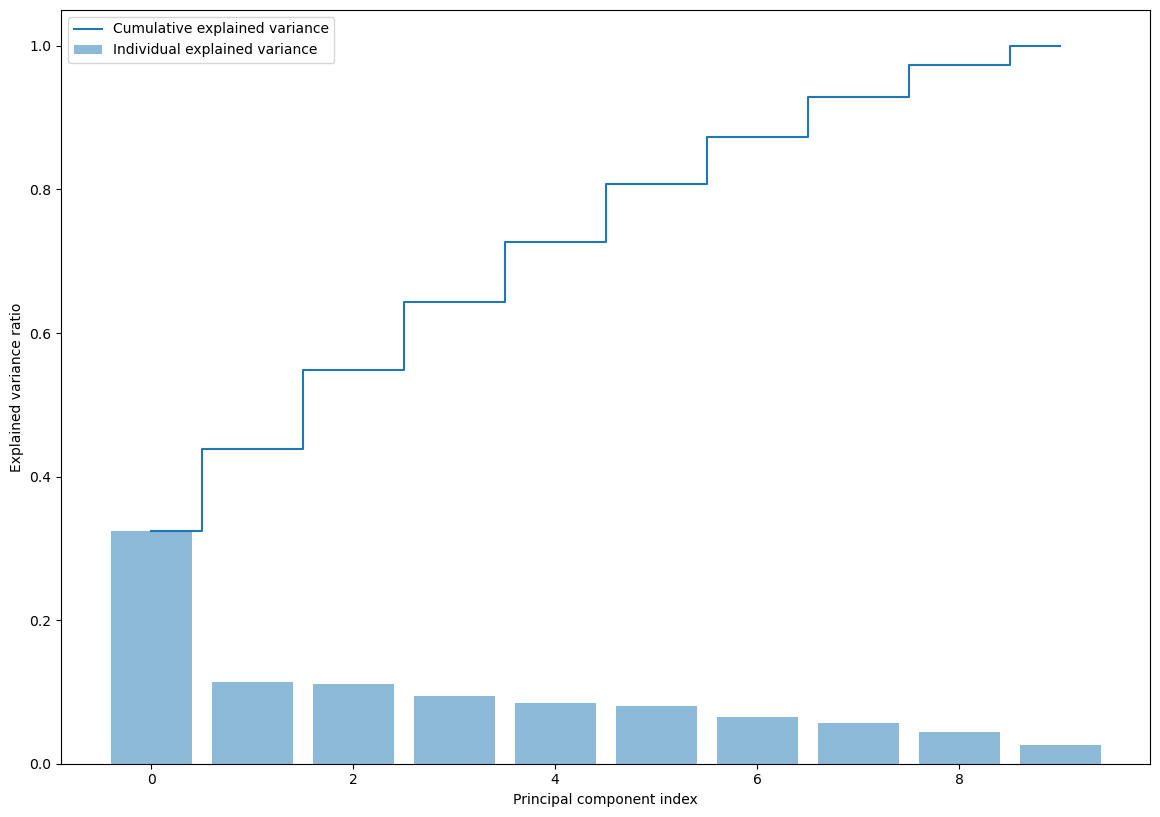

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features  = BF_CTU_df.columns.drop("CONDITION")
feature_values = BF_CTU_df.loc[:, features].values #separating the features
feature_values_std = StandardScaler().fit_transform(feature_values)

#Finding explained variance for PCA
pca = PCA()
feature_values_pca = pca.fit_transform(feature_values_std) #Determine transformed feature
exp_var_pca = pca.explained_variance_ratio_ #Determine explained variance using explained_variance_ration_ attribute

cum_sum_eigenvalues = np.cumsum(exp_var_pca) #Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#We can see that the first 6 components captures 80% of the total variance. Thus, I will try PCA with 6 components. 

In [68]:
principalComponents = PCA(n_components=6).fit_transform(feature_values_std)

principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['pc_1', 'pc_2',
                                      'pc_3','pc_4',
                                      'pc_5',  'pc_6'])

BF_CTU_df_pca = pd.concat([principalDf, df[['CONDITION']]], axis = 1)

BF_CTU_df_pca

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,CONDITION
0,-0.711549,-0.397847,-0.102493,-1.181240,0.730848,0.517041,H
1,0.267782,-0.954637,0.151185,-0.335861,-0.776864,0.025990,H
2,0.401326,-0.977349,0.173633,-0.247962,-0.700432,0.354232,H
3,0.393084,0.291764,3.268673,0.078383,0.139800,0.821688,H
4,-1.082353,-1.938582,-0.392552,0.372578,-0.691004,0.186644,H
...,...,...,...,...,...,...,...
437,-0.386544,-0.848308,-0.313077,0.694784,-1.397334,-0.970228,D
438,-1.688772,1.410698,-0.603142,0.372136,-0.391381,0.473340,D
439,-1.631414,-0.895776,-0.901828,0.297148,-0.127363,-0.098046,D
440,-1.526568,-0.485039,0.242394,-0.052562,-0.783093,-0.061020,D


Cross-Validated F1-Score - Logistic Regression: 0.8166888037619323
Cross-Validated F1-Score - Random Forest: 0.8248340779352914
Cross-Validated F1-Score - SVM: 0.8174075224762861
Cross-Validated F1-Score - XGBoost: 0.7986955660609631


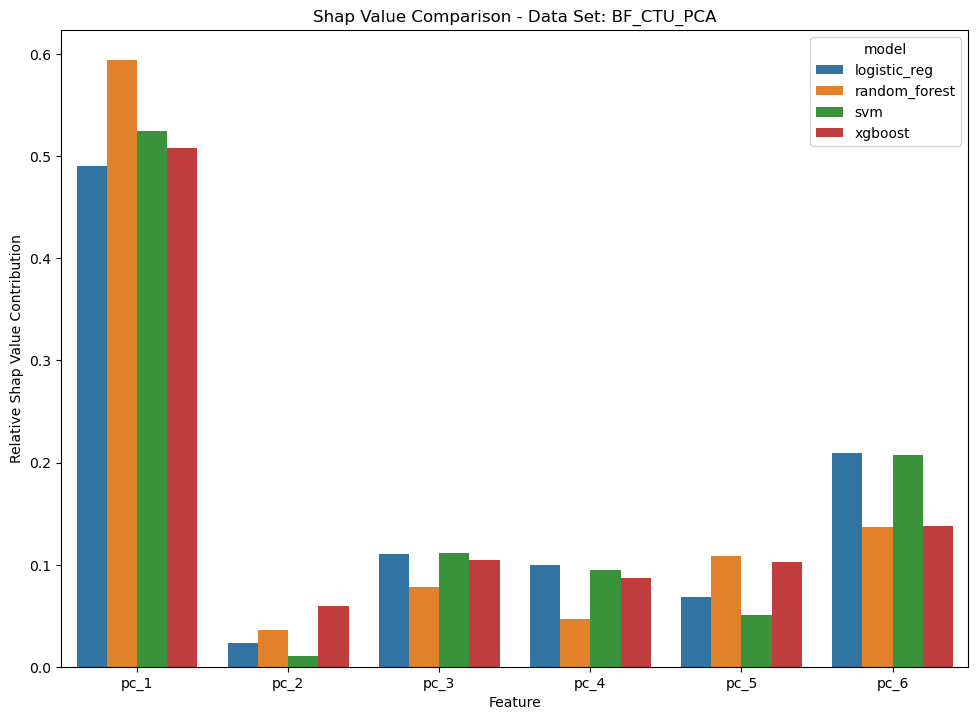

In [54]:
compare_clfs(BF_CTU_df_pca, df_name="BF_CTU_PCA")

### Sparce-PCA

In [73]:
from sklearn.decomposition import SparsePCA

X = df.loc[:, df.columns != 'CONDITION'] # select all columns except CONDITION

X_std = StandardScaler().fit_transform(X)
X_sparce_pca = SparsePCA(n_components=6, random_state=42).fit_transform(X_std)

In [74]:
principalDf = pd.DataFrame(data = X_sparce_pca,
                           columns = ['pc_1', 'pc_2',
                                      'pc_3','pc_4',
                                      'pc_5',  'pc_6'])

BF_CTU_df_spca = pd.concat([principalDf, df[['CONDITION']]], axis = 1)

Cross-Validated F1-Score - Logistic Regression: 0.8144600439006368
Cross-Validated F1-Score - Random Forest: 0.829179133877936
Cross-Validated F1-Score - SVM: 0.8248975118662516
Cross-Validated F1-Score - XGBoost: 0.7988883090337802


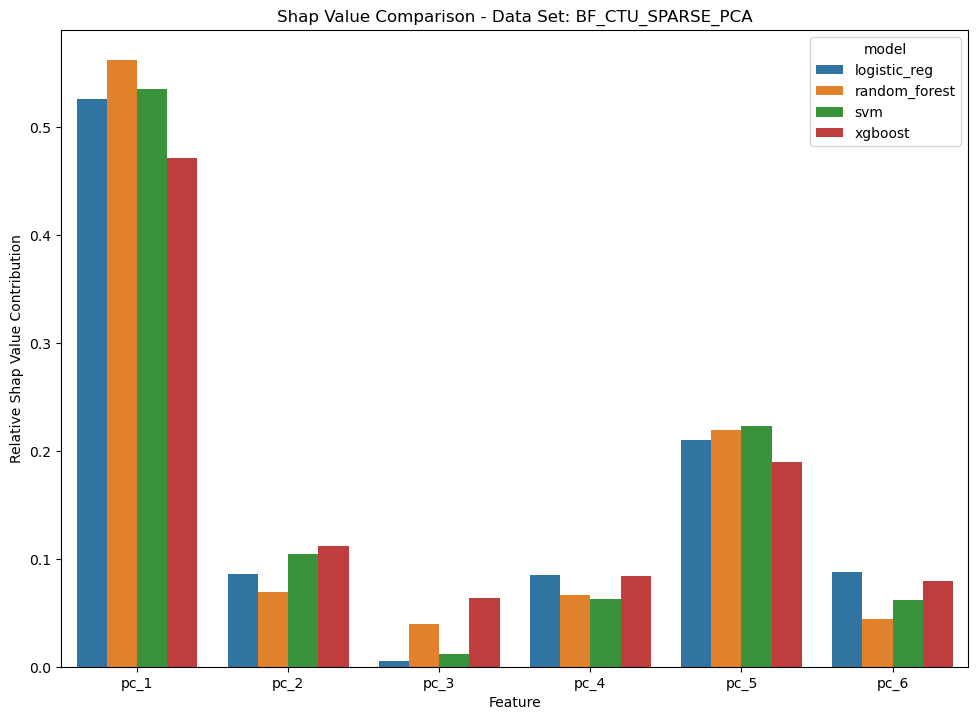

In [76]:
compare_clfs(BF_CTU_df_spca, df_name="BF_CTU_SPARSE_PCA")

### Autoencoder Thing

### Etc

Feature importance scores can be fed to a wrapper model, such as the "SelectFromModel" class, to perform feature selection.

Way to calculate features importances:
- Coefficient statistic between each features